# Introduzione

Questo progetto mira a condurre un’analisi approfondita del dataset Breast Cancer Wisconsin (Diagnostic), derivato dallo studio di Street, Wolberg e Mangasarian (1993).
Il dataset contiene misurazioni morfologiche e di texture dei nuclei cellulari ottenute da immagini digitali di aspirazioni con ago sottile di tessuto mammario.
L’obiettivo principale è applicare tecniche di data mining e machine learning per classificare accuratamente i campioni come benigni o maligni, sulla base delle caratteristiche estratte dalle immagini.

Le feature rappresentano parametri geometrici e strutturali dei nuclei, tra cui:
	•	dimensione (raggio, area, perimetro),
	•	forma (compattezza, concavità, simmetria, dimensione frattale),
	•	texture (varianza di intensità dei pixel).

Ogni immagine è descritta da 30 variabili numeriche, derivate da 10 misure di base (media, deviazione standard ed estremo superiore per ciascuna).
L’analisi esplorativa si concentrerà sull’identificazione delle relazioni tra queste feature e sulla loro capacità di discriminare tra tessuti benigni e maligni, con l’obiettivo finale di sviluppare un modello predittivo robusto e interpretabile.



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import parallel_coordinates

# --- Per il Caricamento Dati  ---
from sklearn.datasets import fetch_openml

# --- Per Preprocessing e Valutazione ---
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# --- Per i Modelli di Classificazione ---
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import xgboost as xgb

In [5]:
## --- ANALISI ESPLORATIVA ---

# 1. Carica il dataset (ID 1510)
try:
    data_bunch = fetch_openml(data_id=1510, as_frame=True, parser='auto')
except Exception as e:
    print(f"Errore nel caricamento dati: {e}")

# 2. DataFrame
df = data_bunch.frame

# 3. Colonna target
class_column_name = data_bunch.target_names[0]
print(f"Identificata la colonna target: '{class_column_name}'")

# 4. Controllo nomi colonne
if df.columns.str.startswith('V').any():
    feature_column_names = [
        'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean',
        'compactness_mean', 'concavity_mean', 'concave_points_mean', 'symmetry_mean', 'fractal_dimension_mean',
        'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
        'compactness_se', 'concavity_se', 'concave_points_se', 'symmetry_se', 'fractal_dimension_se',
        'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst',
        'compactness_worst', 'concavity_worst', 'concave_points_worst', 'symmetry_worst', 'fractal_dimension_worst'
    ]
    df.columns = feature_column_names + [class_column_name]
else:
    feature_column_names = data_bunch.feature_names
    print("Nomi delle colonne già corretti.")

# 5. Analisi preliminare
print("\n--- Prime 5 righe del DataFrame Combinato ---")
print(df.head())

print("\n--- Informazioni (Tipi di dati e Valori Mancanti) ---")
df.info()

# 6. Analisi sbilanciamento classi
print("\n--- Distribuzione delle Classi (Valori Originali) ---")
print(df[class_column_name].value_counts())

Identificata la colonna target: 'Class'

--- Prime 5 righe del DataFrame Combinato ---
   radius_mean  texture_mean  perimeter_mean  area_mean  smoothness_mean  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   compactness_mean  concavity_mean  concave_points_mean  symmetry_mean  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430         0.1809   

   fr

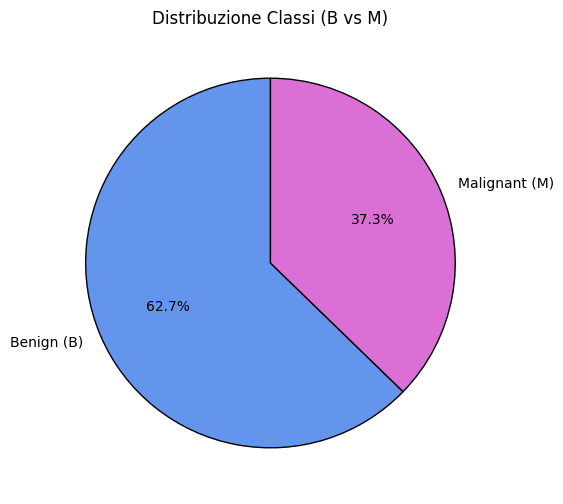

In [6]:
## VISUALIZZAZIONI (Blocco 2.1: Grafico a Torta) ---

# 1. Mappatura delle classi
class_map = {'1': 'Benign (B)', '2': 'Malignant (M)'}
color_map_dict = {'Benign (B)': 'cornflowerblue', 'Malignant (M)': 'orchid'}

# Copia e crea la colonna etichettata
df_plot = df.copy()
df_plot['Diagnosis_Label'] = df[class_column_name].map(class_map)

# 2. Grafico a Torta (Distribuzione Classi)
plt.figure(figsize=(6, 6))

# Conta le classi e ordina
counts = df_plot['Diagnosis_Label'].value_counts()

# Applica la color map in base all’ordine delle etichette
colors = [color_map_dict[label] for label in counts.index]

# Crea il grafico
counts.plot.pie(
    autopct='%1.1f%%',
    colors=colors,
    wedgeprops={'edgecolor': 'black'},
    startangle=90
)

plt.title('Distribuzione Classi (B vs M)')
plt.ylabel('')
plt.show()

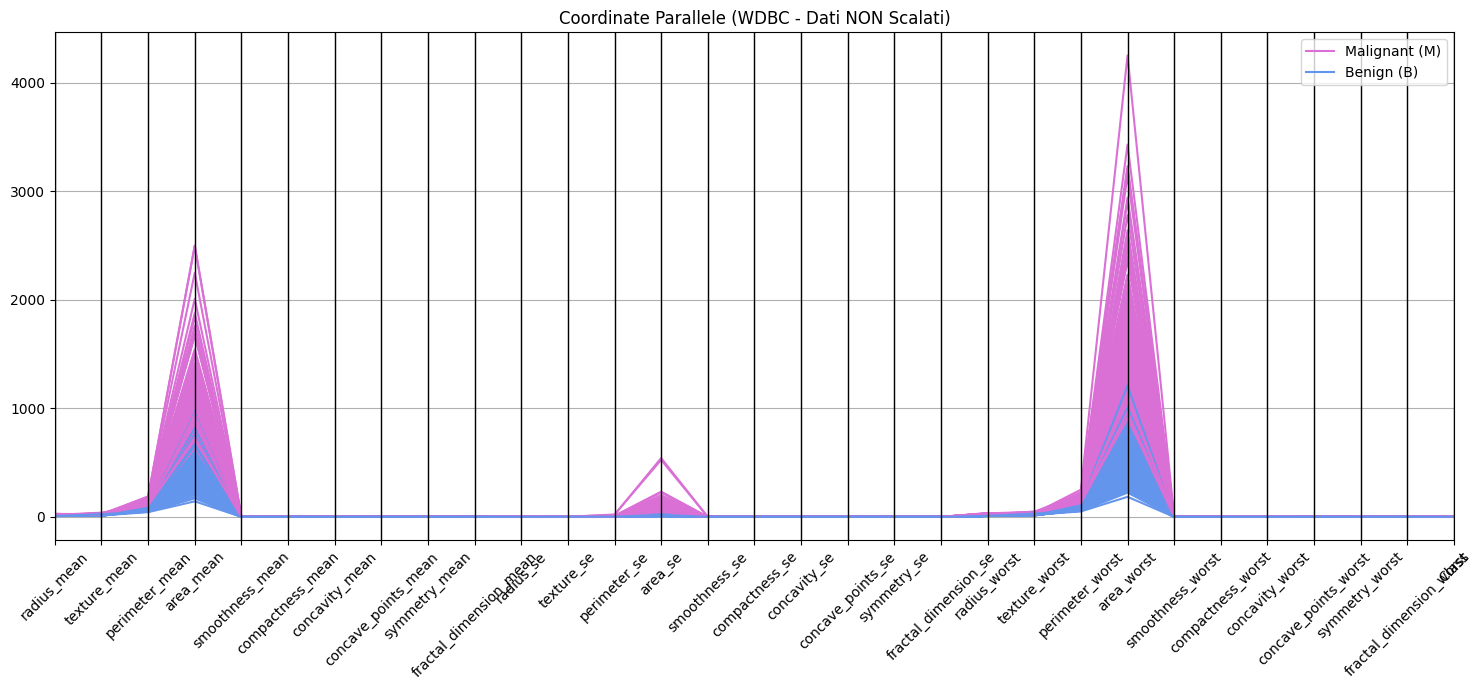

In [21]:
## VISUALIZZAZIONI (Blocco 2.2: Coordinate Parallele - NON Scalati) ---

plt.figure(figsize=(15, 7))

# Ottieni l'ordine delle classi effettive nel DataFrame
class_order = df_plot['Diagnosis_Label'].unique()

# Applica la color map in base all'ordine
colors = [color_map_dict[label] for label in class_order]

# Grafico delle coordinate parallele
parallel_coordinates(df_plot, 'Diagnosis_Label', color=colors)

plt.title('Coordinate Parallele (WDBC - Dati NON Scalati)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

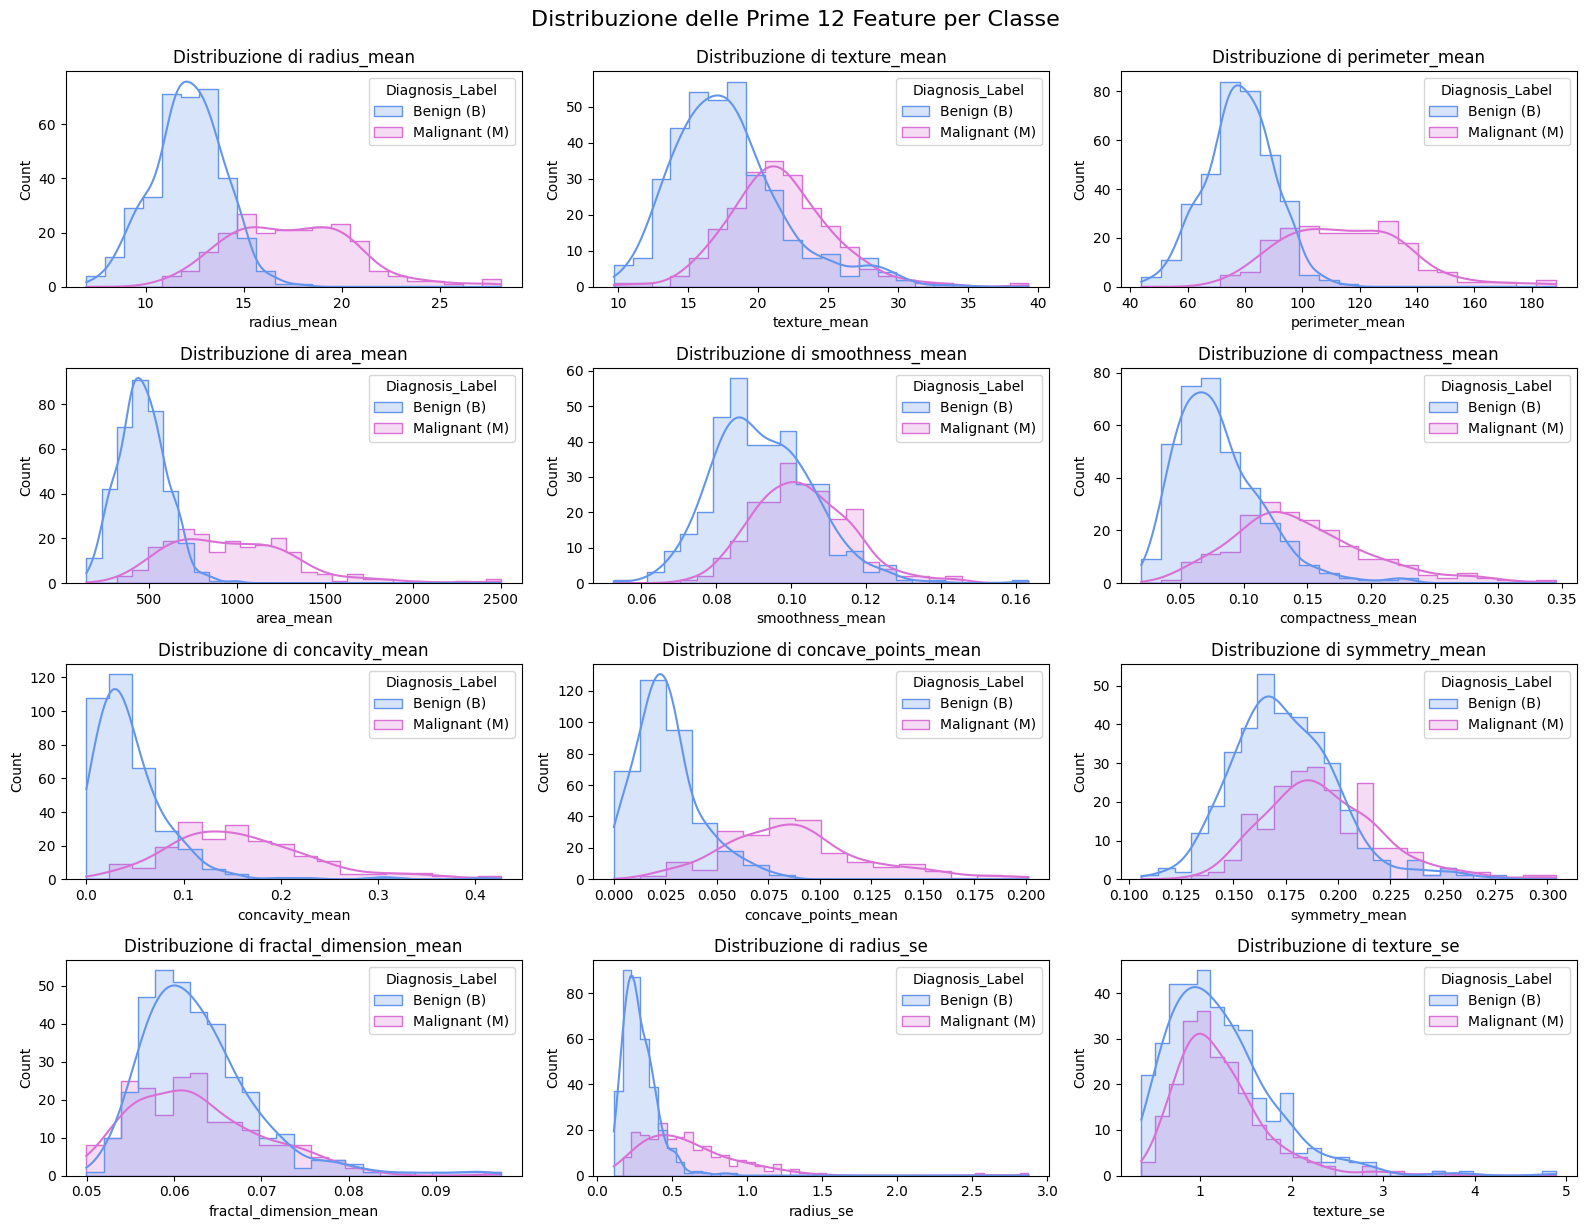

In [8]:
# Prime 12 feature 
features_to_plot = feature_column_names[0:12]

# Costruisci la palette 
palette = {label: color for label, color in color_map_dict.items()}

plt.figure(figsize=(16, 12))
for i, feature in enumerate(features_to_plot):
    plt.subplot(4, 3, i + 1)
    sns.histplot(
        df_plot,
        x=feature,
        hue='Diagnosis_Label',
        kde=True,
        palette=palette,
        element='step'
    )
    plt.title(f'Distribuzione di {feature}')

plt.tight_layout()
plt.suptitle('Distribuzione delle Prime 12 Feature per Classe', y=1.02, fontsize=16)
plt.show()

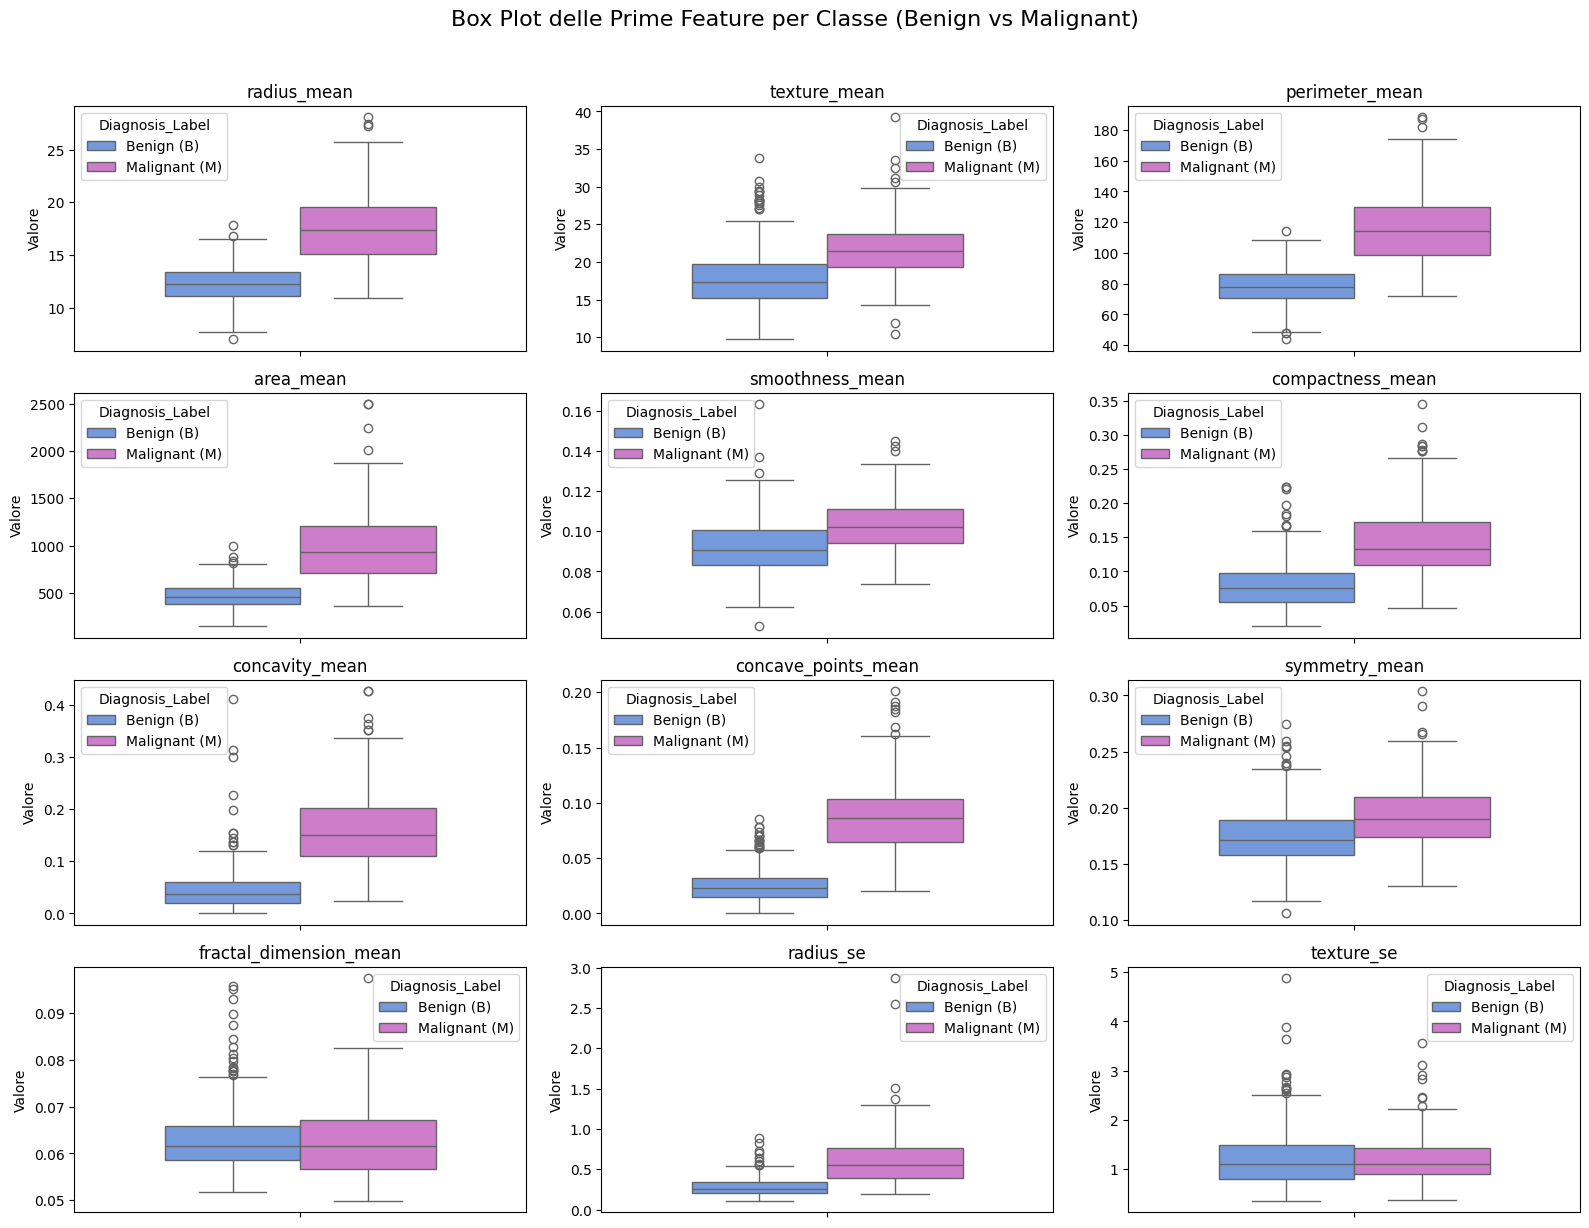

In [19]:
## --- VISUALIZZAZIONI (Blocco 2.5: Box Plot) ---


# Selezioniamo le prime 12 feature
features_to_plot = feature_column_names[:12]  

plt.figure(figsize=(16, 12))
for i, feature in enumerate(features_to_plot):
    plt.subplot(4, 3, i + 1)
    sns.boxplot(
        df_plot,
        hue='Diagnosis_Label',
        y=feature,
        palette=color_map_dict,
        width=0.6
    )
    plt.title(feature)
    plt.xlabel('')
    plt.ylabel('Valore')

plt.suptitle('Box Plot delle Prime Feature per Classe (Benign vs Malignant)', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

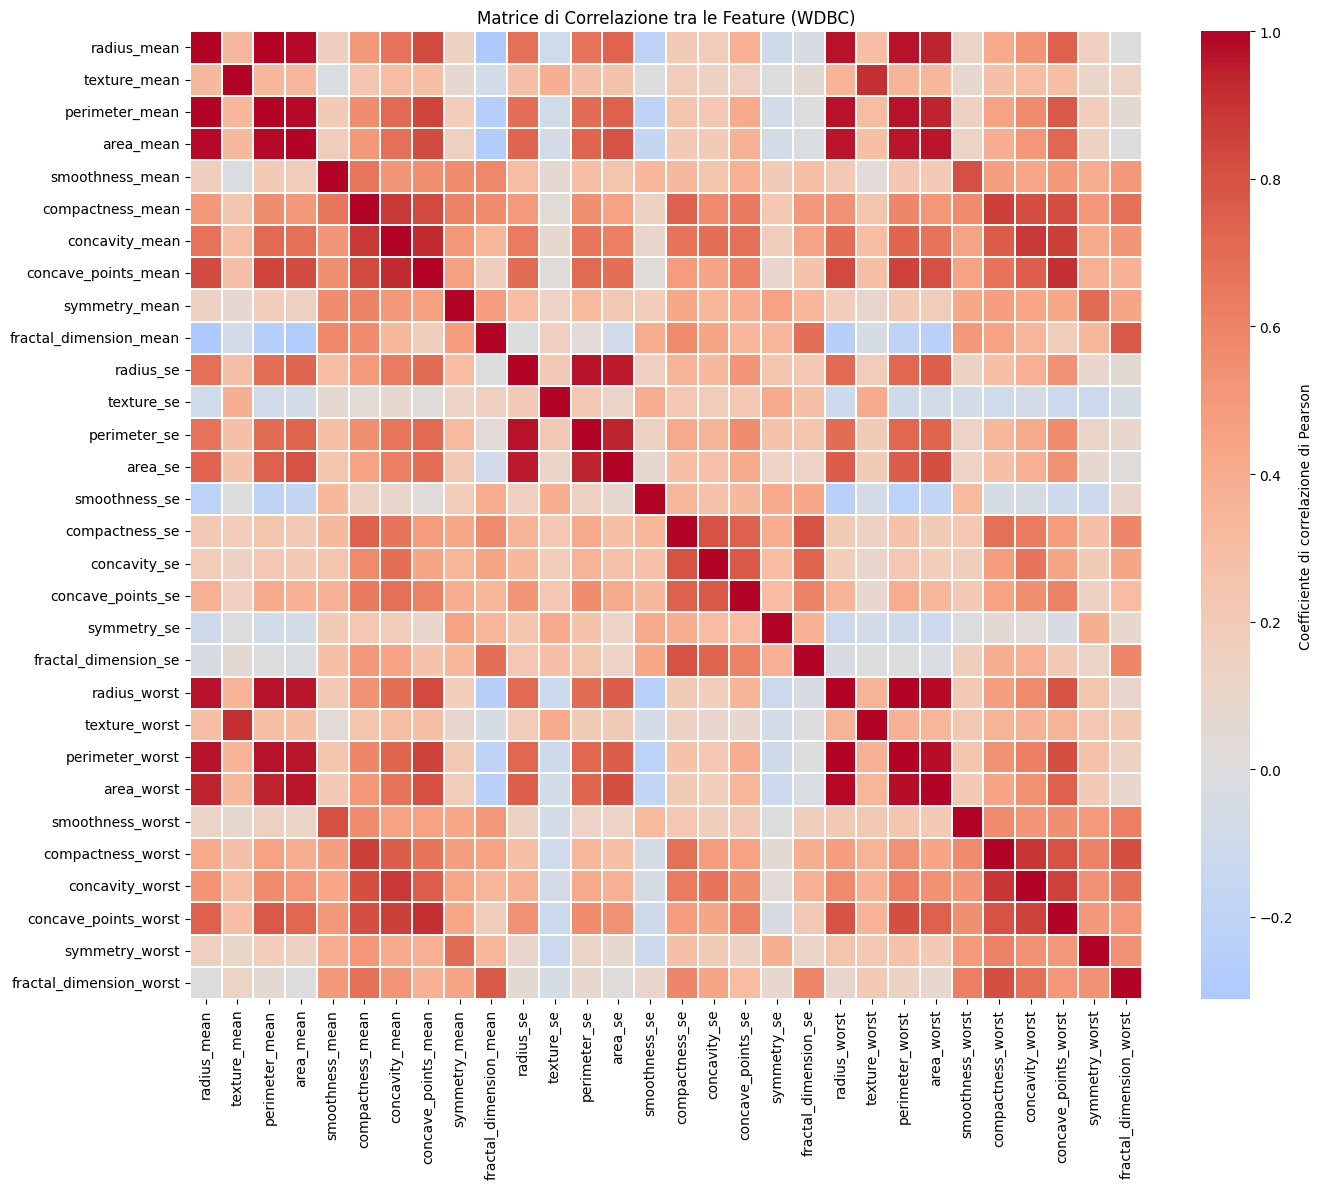

In [15]:
## --- VISUALIZZAZIONI (Blocco 2.4: Matrice di Correlazione) ---

# Calcolo della matrice di correlazione
corr_matrix = df[feature_column_names].corr()

plt.figure(figsize=(14, 12))
sns.heatmap(
    corr_matrix,
    cmap='coolwarm',        
    center=0,             
    annot=False,
    linewidths=0.3,
    cbar_kws={'label': 'Coefficiente di correlazione di Pearson'}
)
plt.title('Matrice di Correlazione tra le Feature (WDBC)')
plt.tight_layout()
plt.show()

In [ ]:
## --- PREPROCESSING ---

# 1. Separa X (features) e y (target) dal DataFrame originale
X = df.drop(class_column_name, axis=1)
y = df[class_column_name]

# 2. Encoding del Target (da '2'/'1' a 1/0)
# '2' (Maligno) -> 1
# '1' (Benigno) -> 0
y_numeric = y.map({'2': 1, '1': 0})
print(f"\nTarget convertito in numerico (0=Benigno, 1=Maligno):\n{y_numeric.value_counts()}")


# 3. Divisione in Train/Test 
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y_numeric, 
    test_size=0.3,
    random_state=42,
    stratify=y_numeric 
)

print(f"\nDati di Addestramento (X_train): {X_train.shape}")
print(f"Target di Addestramento (y_train): {y_train.shape}")
print(f"Dati di Test (X_test): {X_test.shape}")
print(f"Target di Test (y_test): {y_test.shape}")



Target convertito in numerico (0=Benigno, 1=Maligno):
Class
0    357
1    212
Name: count, dtype: int64

Dati di Addestramento (X_train): (398, 30)
Target di Addestramento (y_train): (398,)
Dati di Test (X_test): (171, 30)
Target di Test (y_test): (171,)


In [ ]:
#4. Standardizzazione delle variabili
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
